In [ ]:
pip install catboost

     |████████████████████████████████| 66.3MB 52kB/s 


In [ ]:
import pandas as pd
import numpy as np

from math import sqrt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import seaborn as sns
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression




In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Diwali Hackathon/Train.csv")

In [ ]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35


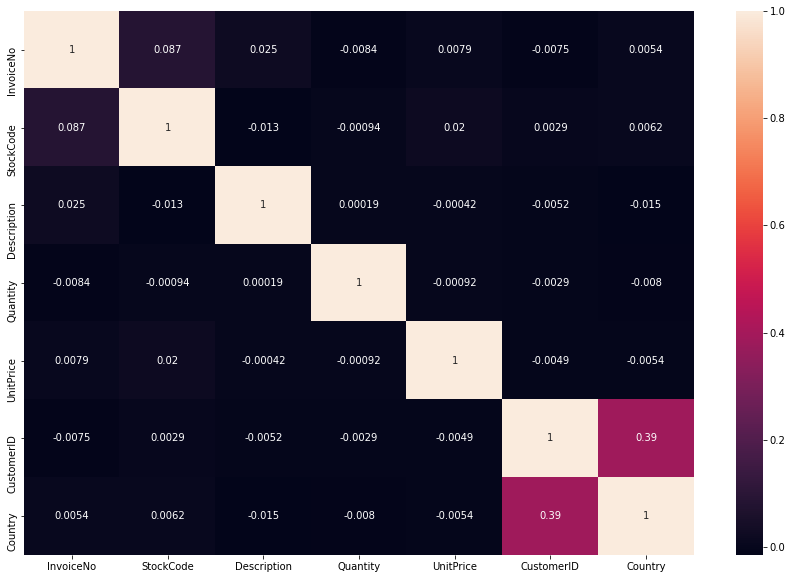

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [ ]:
df=df[df['StockCode']>0]

In [ ]:

df=df[df['Country']>0]

In [ ]:
df=df[df['Description']>0]

In [ ]:
df=df[df['UnitPrice']>0]

In [ ]:
df=df[df['Quantity']>0]

In [ ]:
df['UnitPrice']=np.log(df['UnitPrice'])

In [ ]:
df.shape

(277687, 8)

In [ ]:
df['InvoiceDate'] =pd.to_datetime(df['InvoiceDate'],format='%Y-%m-%d %H:%M:%S')

In [ ]:
df['year'] = df['InvoiceDate'].dt.year
df['month'] = df['InvoiceDate'].dt.month
df['day'] = df['InvoiceDate'].dt.day
df['hour'] = df['InvoiceDate'].dt.hour
#df['quater']=df['InvoiceDate'].dt.quarter

#df['is_weekend'] = np.where(df['dayofweek_name'].isin(['Sunday','Saturday']),1,0)

In [ ]:
df['season'] = (df['InvoiceDate'].dt.month%12 + 3)//3

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day,hour,season
0,6141,1583,144,3,2011-05-06 16:54:00,1.321756,14056.0,35,2011,5,6,16,2
1,6349,1300,3682,6,2011-05-11 07:35:00,0.667829,13098.0,35,2011,5,11,7,2
2,16783,2178,1939,4,2011-11-20 13:20:00,1.783391,15044.0,35,2011,11,20,13,4
3,16971,2115,2983,1,2011-11-22 12:07:00,-0.186330,15525.0,35,2011,11,22,12,4
4,6080,1210,2886,12,2011-05-06 09:00:00,0.500775,13952.0,35,2011,5,6,9,2


In [ ]:
X=df[['StockCode','Description','Quantity','CustomerID','Country','year','month','day','hour','season']]

In [ ]:
y=df['UnitPrice']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
lr=LinearRegression()

In [ ]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
preds=lr.predict(X_test)

In [ ]:
print(np.sqrt(mean_squared_error(y_test,preds)))

0.919324591471592


In [ ]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse = make_scorer(RMSE, greater_is_better=False)

In [ ]:
def etc_cv(n_estimators, min_samples_split, max_features, data, targets):
    estimator = ExtraTreesRegressor(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2,
        n_jobs = -1
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [ ]:
def optimize_etc(data, targets):
    def etc_crossval(n_estimators, min_samples_split, max_features):
        return etc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=etc_crossval,
        pbounds={
            "n_estimators": (100, 400),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)

    print("Final result:", optimizer.max)

In [ ]:
print("--- Optimizing EXB Regressor ---")
optimize_etc(X_train, y_train)


--- Optimizing EXB Regressor ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -0.6435   |  0.2722   |  16.31    |  231.3    |
|  2        | -0.2172   |  0.806    |  19.94    |  181.8    |
|  3        | -0.549    |  0.3485   |  20.44    |  387.4    |
|  4        | -0.1902   |  0.8875   |  10.23    |  250.3    |
|  5        | -0.2455   |  0.7144   |  18.39    |  211.1    |
|  6        | -0.2711   |  0.6045   |  13.57    |  104.1    |
|  7        | -0.2562   |  0.7948   |  22.3     |  209.5    |
|  8        | -0.2289   |  0.6532   |  3.734    |  210.6    |
|  9        | -0.1888   |  0.9389   |  16.98    |  219.2    |


KeyboardInterrupt: ignored

In [ ]:

etc =ExtraTreesRegressor(n_estimators=int(219.2),
                         min_samples_split=int(16.98),
                         max_features=0.9389,random_state=42)

In [ ]:
etc.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=0.9389, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=16, min_weight_fraction_leaf=0.0,
                    n_estimators=219, n_jobs=None, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [ ]:
preds=etc.predict(X_test)

In [ ]:
print(np.sqrt(mean_squared_error(y_test,preds)))

0.17547665951117522


**Testing** **Data**

In [ ]:
test_df=pd.read_csv("/content/drive/MyDrive/Diwali Hackathon/Test.csv")

In [ ]:
test_df['InvoiceDate'] =pd.to_datetime(test_df['InvoiceDate'],format='%Y-%m-%d %H:%M:%S')

In [ ]:
test_df['year'] = test_df['InvoiceDate'].dt.year
test_df['month'] = test_df['InvoiceDate'].dt.month
test_df['day'] = test_df['InvoiceDate'].dt.day
test_df['hour'] = test_df['InvoiceDate'].dt.hour

In [ ]:
test_df['season'] = (test_df['InvoiceDate'].dt.month%12 + 3)//3

In [ ]:
test_df.drop(['InvoiceDate','InvoiceNo'],axis=1,inplace=True)

In [ ]:
test_df.head()

,StockCode,Description,Quantity,CustomerID,Country,year,month,day,hour,season
0,1709,1079,3,16161.0,35,2011,2,22,15,1
1,510,3457,1,17341.0,35,2010,12,8,12,1
2,604,694,36,15158.0,35,2011,10,25,13,4
3,1478,3473,2,16033.0,35,2011,6,27,12,3
4,3216,871,1,15351.0,35,2011,11,6,16,4


In [ ]:
test_array=test_df.to_numpy()

In [ ]:
preds = etc.predict(test_array)

In [ ]:
preds_df=pd.DataFrame(preds,columns=['UnitPrice'])

In [ ]:
preds_df['UnitPrice']=np.exp(preds_df['UnitPrice'])

In [ ]:
preds_df.head()

,UnitPrice
0,1.693265
1,1.307264
2,3.056908
3,1.747509
4,11.268967


In [ ]:
preds_df.to_csv("prediction26_extra.csv")

In [ ]:
def remove_outliers(df,columnname):
    q25, q75 = np.percentile(df[columnname], 25),np.percentile(df[columnname], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in df[columnname] if x < lower or x > upper]
    for outlier in outliers:
        df=df[df[columnname] != outlier]
    return df 